In [1]:
from datascience import *
import numpy as np
import pandas as pd
from math import *
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## Lesson 35: Regression

Over the last two lessons, you went over regression in Data 8.3x. In these sections, you learned how to calculate the slope and intercept of a line fit to a bivariate sample. For example, using the `baby.csv` dataset, you can use regression to predict birthweight given the gestational age of the baby at birth. 

### Exercise 1

Find the least squares line that predicts birthweight based on the gestational age of a baby. You should use `minimize`, an optimization method in the `datascience` package. Note that you could use standardization (similar to what they did in Data 8.3x, `lec7.ipynb`) but the resulting intercept and slope would be in standardized units, and would need to be transformed in order to be interpretable. 

In [2]:
baby = Table.read_table('Data/baby.csv')
baby.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


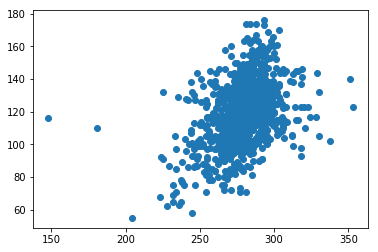

In [3]:
plt.scatter(baby.column(1),baby.column(0))
plt.show()

In [4]:
def avgSqErr(xData, yData, slope, intercept):
    '''This function gives the average squared error of a dataset and line'''
    return np.mean( (yData - (xData*slope + intercept))**2 )

def fitLine(xData, yData):
    '''This function returns the least squared error linear regression for the dataset
    Returns an array in the form [slope, intercept].'''
    def specErr(slope, intercept):
        return avgSqErr(xData, yData, slope, intercept)
    return minimize(specErr)

line = fitLine(baby.column(1), baby.column(0))
babySlope = line[0]
babyInt = line[1]
line

array([ 0.4284037 , -0.07039869])

In the context of the data, interpret the intercept and slope. 

*At birth, a typical baby's weight can be estimated by assuming that it gains 0.428 units of weight per gestational day, with an initial weight of -0.07 units at day 0*

The slope is 0.428. It seems reasonable to expect this slope to be significantly higher than zero; it makes sense that gestational age would impact birthweight. Let's check using bootstrapping. 

In [5]:
slopes = make_array()
intercepts = make_array()

for _ in np.arange(10000):
    #get bootstrap data, ensuring x and y data remain paired
    sampleData = baby.sample()
    line = fitLine(sampleData.column(1), sampleData.column(0))
    slopes = np.append(slopes, line[0])
    intercepts = np.append(intercepts, line[1])

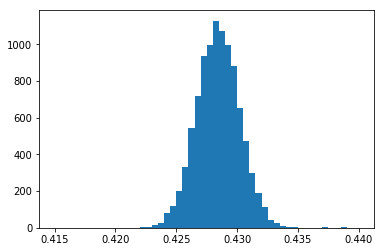

In [6]:
# Plot it!
plt.hist(slopes, np.arange(0.415, 0.44, 0.0005));

In [7]:
# Analyze the bootrapped slope data
def ConfInt(data, confidence):
    return [np.percentile(data, (100-confidence)/2), np.percentile(data, 100-(100-confidence)/2)]
ConfInt(slopes, 95)

[0.42497001908755294, 0.4322540537472037]

*From a large bootstrap sample, we can be 95% confident that the slope lies between 0.425 and 0.432.*

### Exercise 2

For a baby born at 40 weeks gestational age, what do we expect to be the average birthweight according to this model?

In [8]:
babySlope*(40*7) + babyInt

119.88263715253427

Using bootstrapping, build a 95% confidence interval around this estimate. Interpret this interval, carefully. 

In [9]:
# Let's use the previously generated bootstrap sample of slopes & intercepts
# We'll generate an expected average birthweight for each bootstrapped best-fit line
fit40strapped = slopes*(40*7) + intercepts
ConfInt(fit40strapped, 95)

[118.91825856549409, 120.86767580455617]

*Our confidence interval indicates that we can be 95% confident that the data's **expected** birthweight for a 40-week baby is between 118.9 and 120.9 units of weight.*

This is a confidence inteval on the **mean** birthweight for a baby born at 40 weeks. 

### Exercise 3

Suppose a baby is born at 40 weeks. Let's construct a confidence interval for the birthweight of *that baby*. This is different than the confidence interval on the mean birthweight of babies born at 40 weeks. This interval is known as a prediction interval. 

A simple way to find the prediction interval is to sample many times (with replacement) from the observed residuals and add to the predicted birthweight under the linear model. Find the percentiles of these simulations to obtain the interval. 

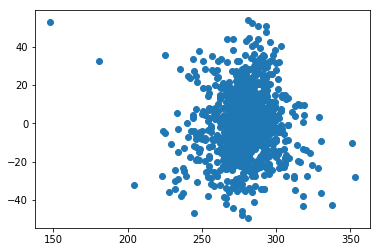

In [10]:
# First get the residuals from our best-fit line
residuals =  baby.column(0) - ( baby.column(1)*babySlope + babyInt)
plt.scatter(baby.column(1), residuals);

It turns out that this method is a little oversimplified. A "more correct" method is below. This requires taking into account the *leverage* of each data point (basically a measure of impact to the model of each data point). 

In [14]:
slope = babySlope
intercept = babyInt
pred=intercept+slope*150
leverage=1/baby.num_rows + ((baby.column(1)-np.mean(baby.column(1)))**2)/np.sum(((baby.column(1)-np.mean(baby.column(1)))**2))
adjresiduals=residuals/np.sqrt(1-leverage)

bs_all=[]
for _ in np.arange(5000):
    bs_y=(intercept+slope*baby.column(1))+np.random.choice(adjresiduals,size=baby.num_rows,replace=True)
    resample=Table().with_columns("y",bs_y,"x",baby.column(1))
    bs_slope,bs_intercept=minimize(mse_resample)
    bs_residuals=bs_y-(bs_intercept+bs_slope*baby.column(1))
    bs_adjresiduals=bs_residuals/np.sqrt(1-leverage)
    bs_all=np.append(bs_all,150*(slope-bs_slope)+np.random.choice(bs_adjresiduals))

percentile([2.5,97.5],pred+bs_all)

NameError: name 'mse_resample' is not defined